# Stock Price Predictor - Model Training and Testing

## Notebook Overview
- [1. ARIMA Model](#ARIMA-Model)
    - [1.1 Loading data](#load-data-1)
    - [1.2 Determine Parameters](#define-parameters-1)
    - [1.3 Train ARIMA Model](#train-model-1)
    - [1.4 Evaluate Model Perfomance](#evaluate-performance-1)
    - [1.5 Hyperparameter Tuning - ARIMA](#hyperparameter-tuning-1)
    - [1.6 Generate Predictions - ARIMA](#generate-predictions-1)
- [2. DeepAR Model](#DeepAR-Model)
    - [2.1 Loading Data](#load-data-2)
    - [2.2 Setting Hyperparameters](#define-hyperparameters-2)
    - [2.3 Train DeepAR Estimator](#train-model-2)
    - [2.4 Deploy and Evaluate Model Perfomance](#evaluate-performance-2)
    - [2.5 Hyperparameter Tuning - DeepAR](#hyperparameter-tuning-2)
    - [2.6 Generate Predictions - DeepAR](#generate-predictions-2)
- [3. Visualise and Compare Predictions](#visualise-results)
- [4. Experimentation](#experimentation)
- [5. Conclusion](#conclusion)

## Plan of Action
ARIMA and DeepAR models will be trained and their predictions will be saved, visualised and compared in this notebook.

<a id="load-data-1"></a>
## 1.1 Load Data

In [1]:
import os
import pytz
import json
import math
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_squared_error

pd.set_option('display.max_rows', None)
timezone_str = 'Asia/Kolkata'
localtz = pytz.timezone(timezone_str)

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings(action='once')

csv_data_dir = 'data/csv_aapl_data'
json_data_dir = 'data/json_aapl_data'

In [2]:
!pip install jupyternotify --quiet
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
!jupyter nbextension enable --py widgetsnbextension
%load_ext jupyternotify

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


<IPython.core.display.Javascript object>

In [3]:
# Load stocks data
stock_names = {'^GSPC': 'S&P 500',
               '^BSESN': 'S&P BSE SENSEX',
               'AAPL': 'Apple Inc.'}

data_dir = 'data'
data = {}

for stock in stock_names.keys():
    data[stock] = pd.read_csv(os.path.join(data_dir, stock + '.csv'),
                              parse_dates=True, index_col=['Date'])
    data[stock] = data[stock].dropna()
    
df = data['AAPL'].index
idx = pd.date_range(min(df.date), max(df.date))
aapl_updated = data['AAPL'].copy().reindex(idx)

<a id="ARIMA-Model"></a>
# 1. ARIMA Model
## Import Data

In [17]:
# Import one time series data
csv_data_dir = 'data/csv_aapl_data'

arima_train = pd.read_csv(os.path.join(csv_data_dir, 'train.csv'), parse_dates=[0], index_col=0, squeeze=True)
arima_test = pd.read_csv(os.path.join(csv_data_dir, 'test.csv'), parse_dates=[0], index_col=0, squeeze=True)
arima_test.head()

2002-01-01         NaN
2002-01-02    0.359544
2002-01-03    0.363864
2002-01-04    0.365562
2002-01-05         NaN
Name: Adj Close, dtype: float64

## 1.1 Determine Parameters
ARIMA model requires three parameters to be defined.
1. Number of `auto-regressive terms` (p)
2. Number of `differences` (d)
3. Number of `moving average terms` (q)

Values `p` and `q` can be determined using `ACF` and `PACF` plots and can further be improved by minimizing `AIC` and `BIC` values (more on the metrics). While `d` can be determined using the stationarity of the time series. The stationarity of a time series will be measured using the `Dickey-Fuller Test` and plot of the modified series.

> **Source**: Jain, A. (2016) Time Series Forecasting In Python | R. doi: 10.1201/9781420000269.ch12. *Available at: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

In [73]:
def stationarity_stats(time_series: pd.Series, window_size = 10):
    """The function plots and prints the necessary statistics needed to determine if a
    series can be assumed to be stationary.
    
    Args:
        time_series (pd.Series): series that is to be tested for stationarity.
    """
    
    #Determing rolling statistics
    ts_moving_avg = time_series.rolling(window_size).mean()
    ts_moving_std = time_series.rolling(window_size).std()

    #Plot statistics data
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.style.use('seaborn')
    
    time_series.plot(color='blue',
                     ax=ax,
                     label='Time Series')
    ts_moving_avg.plot(color='yellow',
                       ax=ax,
                       label='Moving Average')
    ts_moving_std.plot(color='green',
                       ax=ax,
                       label='Standard Deviation')
    plt.legend(loc='best')
    ax.set_title('Time Series with Moving Avearage & Rolling Standard Deviation',
                 fontdict={'size': 20, 'weight': 'bold'})
    ax.set_xlabel('Timestamp', fontdict={"size": 14})
    ax.set_ylabel('Price ($)', fontdict={"size": 14})
    
    leg = ax.legend(fontsize=16, frameon=True)
    leg.get_frame().set_color('#F2F2F2')
    leg.get_frame().set_edgecolor('black')
    leg.set_title("Legend", prop={"size": 20, "weight": 'bold'})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    
    #Calculate resutls of the Dickey-Fuller test
    test_results = adfuller(time_series, autolag='AIC')
    data = ['Test Statistic',
            'p-value',
            'Number of Lags Used',
            'Number of Observations Used']
    for name, value in zip(data, test_results[:4]):
        print(f'{name}: {value: .4f}')

    for key, value in test_results[4].items():
        print(f'{key} Critical Value: {value: .3f}')

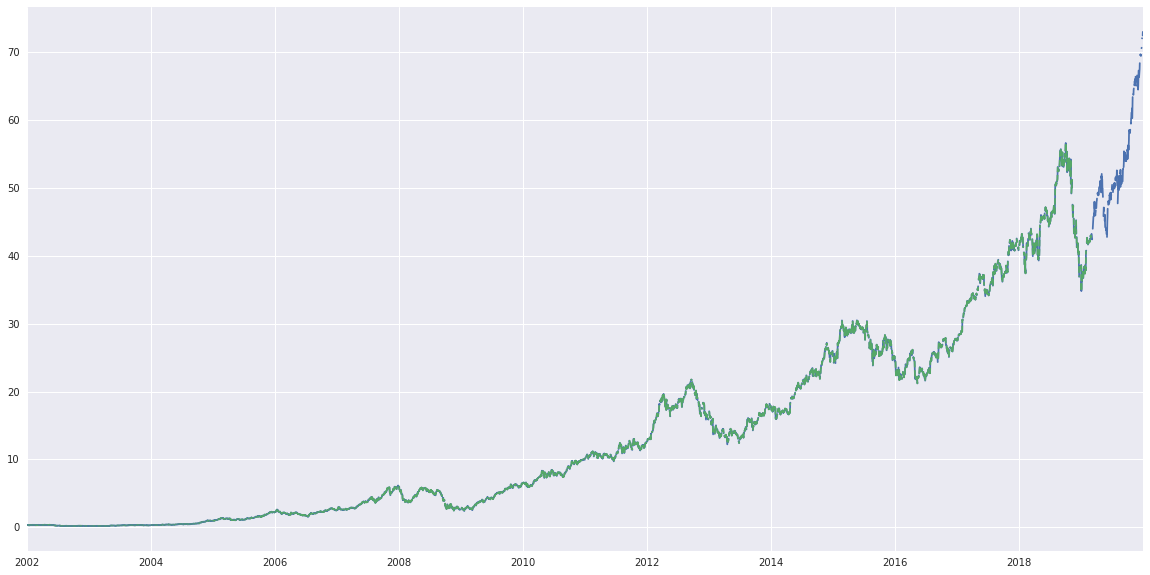

In [104]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ax = arima_test.plot(figsize=(20,10))
arima_train.plot(ax=ax, linestyle='--');

Test Statistic: -11.4251
p-value:  0.0000
Number of Lags Used:  35.0000
Number of Observations Used:  6536.0000
1% Critical Value: -3.431
5% Critical Value: -2.862
10% Critical Value: -2.567


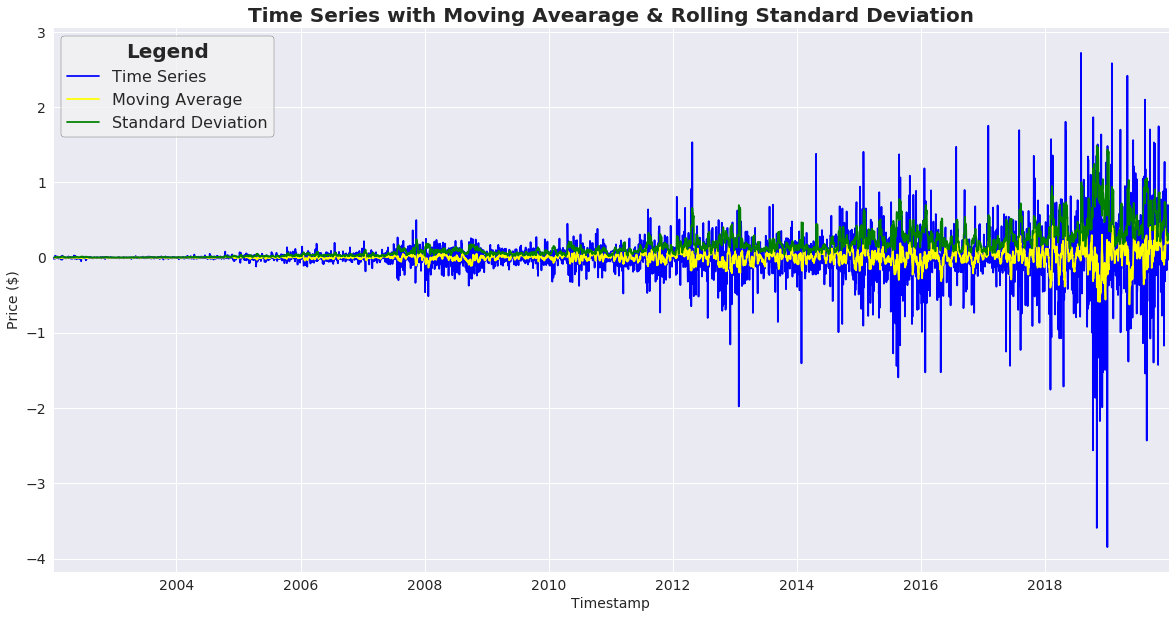

In [74]:
ts = arima_test.interpolate()

ts_diff = ts.diff()
stationarity_stats(ts_diff.dropna())

It can be seen that the `Test Statistic` value of **-11.42** for the test data is less than `1% Critical Value` of **-3.43**. Hence, it can be assumed with 99% confidence that the series is stationary.

However, after viewing the graph, it is clear that the series shows strong signs of being non-stationary towards the end. Log of series can be used to improve the stationarity of the series.

Test Statistic: -27.7753
p-value:  0.0000
Number of Lags Used:  7.0000
Number of Observations Used:  6564.0000
1% Critical Value: -3.431
5% Critical Value: -2.862
10% Critical Value: -2.567


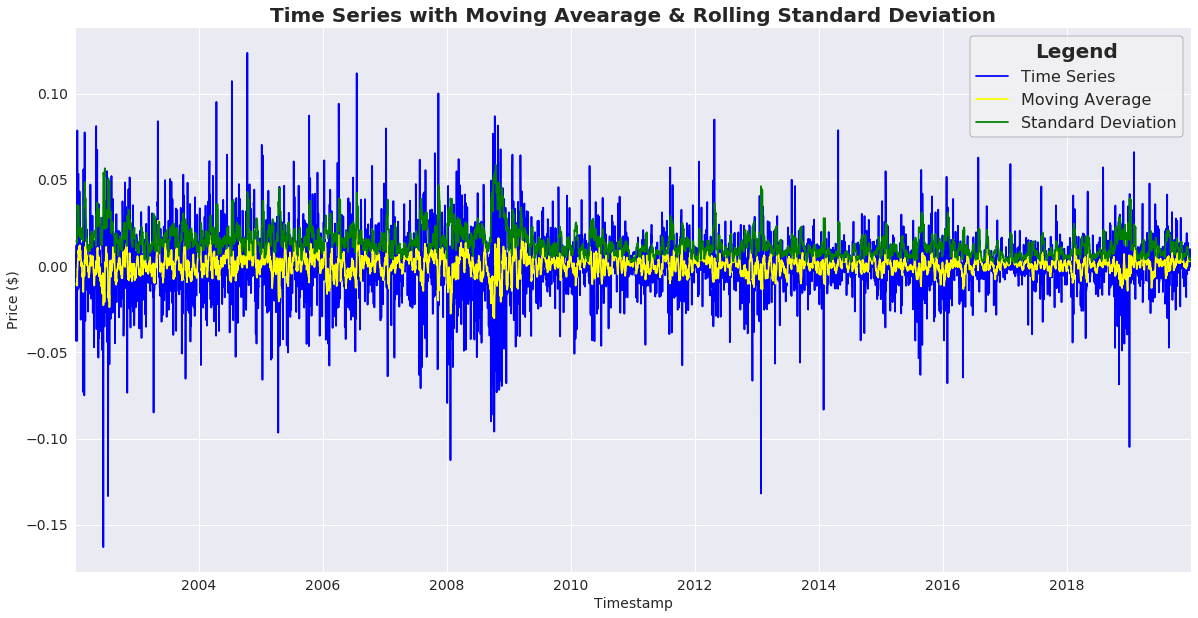

In [75]:
ts_log = np.log(ts)
ts_log_diff = ts_log.diff()
stationarity_stats(ts_log_diff.dropna())

The value of `Test Statistic` has drastically reduced to **-27.95**. Additionally, the graph shows strong signs of stationarity. Hence, `ts_log` should be used to train and test the ARIMA model and the value of `d` should be `0`. Notice the number of lags used is `15`.

*Note: `Decomposing` could further improve the stationarity of the series. This is beyond the scope of this project and can be explored later.*

Determining a valid value of `p` and `q` using `ACF` and `PACF` plots.

In [66]:
def plot_acf_pacf(data_acf, data_pacf):
    # plot data
    fig, axes = plt.subplots(nrows=1,
                             ncols=2,
                             figsize=(20,8))

    plot_titles = ['Autocorreleration Function',
                   'Partial Autocorreleration Function']
    # ax_pacf.plot(data_pacf)

    for ax, title, plot_data in zip(axes, plot_titles, (data_acf, data_pacf)):
        ax.bar(x=range(len(plot_data)), height=plot_data, width=0.1)
        ax.axhline(y=0,linestyle='--',color='gray')
        ax.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='-',color='gray')
        ax.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='-',color='gray')
        ax.set_title(title, fontdict={'size': 20, 'weight': 'bold'})
        ax.set_xlabel('Lag Value')

    fig.suptitle("Autocorrelation Plots of Log of Time Series and First Degree of Differencing",
                  fontsize=24, fontweight= 'bold');

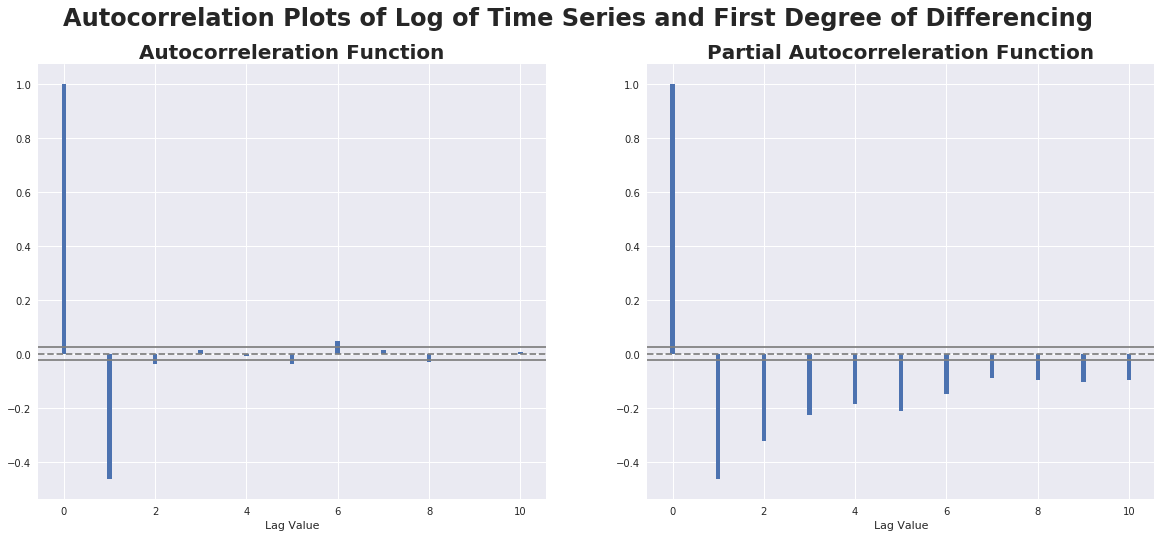

In [100]:
ts_log = ts_log.diff().dropna()

# Calculate values for ACF and PACF
data_acf = acf(ts_log, nlags=10)
data_pacf = pacf(ts_log, nlags=10, method='ols')

plot_acf_pacf(data_acf, data_pacf)

From the above graphs, values of `p` can selected to be `2`. The lag for `q` is much higher and stands at about `2500`. Hence, the parameter values for the ARIMA model should be as follows:
- **Number of `differences` (d) = 1**
- **Number of `auto-regressive terms` (p) = 2**
- **Number of `moving average terms` (q) = 2500**

<a id="train-model-1"></a>
# 1.2 Train ARIMA Model
An ARIMA model will be trained using parameters `(p, d, q) = (2, 1, 2500)`. 

In [77]:
def prepare_data(time_series):
    ts_log = np.log(time_series)
    return ts_log_diff

def reverse_data(ts_log):
    ts = np.exp(ts_log)
    return ts

In [94]:
t0 = time.time()
# Convert train time series into log series
train_ts = prepare_data(arima_train)

# Instantiate and train ARIMA model
arima_model = ARIMA(train_ts, order=(2, 1, 2))

%time
results_arima = arima_model.fit()
print(results_arima.summary())

print(f'Time taken: {round(time.time()-t0, 0)}')

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 6574
Model:                 ARIMA(2, 1, 2)   Log Likelihood               17706.986
Date:                Sat, 31 Oct 2020   AIC                         -35403.972
Time:                        13:31:34   BIC                         -35370.018
Sample:                    01-01-2002   HQIC                        -35392.235
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9236      0.011    -82.613      0.000      -0.945      -0.902
ar.L2          0.0675      0.008      8.036      0.000       0.051 

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [95]:
# %notify
%time
pred_start = max(arima_train.index.date) + pd.DateOffset(days=1)
pred_end = max(arima_test.index.date)

arima_preds = reverse_data(results_arima.predict(start=pred_start, end=pred_end))
idx = pd.date_range(pred_start, pred_end)
arima_preds = arima_preds.reindex(idx)
arima_preds.head()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


2019-03-01    0.999527
2019-03-02    1.001412
2019-03-03    1.000303
2019-03-04    1.000813
2019-03-05    1.000307
Freq: D, dtype: float64

In [96]:
arima_preds.shape, arima_test[pred_start:pred_end].shape

((306,), (306,))

<a id="evaluate-performance-1"></a>
## 1.3 Evaluate Model Perfomance
`Mean Squared Percentage Error (MSPE)` will be used measure the performance of the model.

In [ ]:
# Creating a function to evaluate performance of the model.
def evaluate_model(y_true, y_preds, train_ts=None):
    """The function plots the results obtained on a graph, calculates metric values and returns it.
    
    Args:
        train_ts (pd.Series): the series the model was trained on.
        y_true (pd.Series): true values of the time series.
        y_preds (pd.Series): predicted values of the time series.
        
    Returns:
        dict: with the values of all the metrics printed.
    
    """
    if train_ts is not None:
        pass
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    y_true.plot(ax=ax,
                color='green',
                label='True Series')
    y_preds.plot(ax=ax,
                 color='blue',
                 label='Predicted Series')
    
    plt.legend(loc='best')
    ax.set_title('Time Series Predictions',
                 fontdict={'size': 20, 'weight': 'bold'})
    ax.set_xlabel('Timestamp', fontdict={"size": 14})
    ax.set_ylabel('Price ($)', fontdict={"size": 14})
    
    leg = ax.legend(fontsize=16, frameon=True)
    leg.get_frame().set_color('#F2F2F2')
    leg.get_frame().set_edgecolor('black')
    leg.set_title("Legend", prop={"size": 20, "weight": 'bold'})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # report performance
    performance_dict = {
        "mae": mean_absolute_error(y_true, y_preds),
        "mse": mean_squared_error(y_true, y_preds),
        "rmse": math.sqrt(mean_squared_error(y_true, y_preds)),
        "mape": np.mean(np.abs((y_preds - y_true)/y_true))
    }
    
    print("######### Metric Scores ##########\n"
          "Mean Absolute Error:            {mae: .2f}\n"
          "Mean Squared Error:             {mse: .2f}\n"
          "Root Mean Squared Error:        {rmse: .2f}\n"
          "Mean Absolute Percentage Error: {mape: 0.2%}\n".format(**performance_dict))

    return performance_dict

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
######### Metric Scores ##########
Mean Absolute Error:             52.63
Mean Squared Error:              2830.52
Root Mean Squared Error:         53.20
Mean Absolute Percentage Error:  98.10%



{'mae': 52.625226065700716,
 'mse': 2830.5213689335337,
 'rmse': 53.20264437914279,
 'mape': 0.980973473574011}

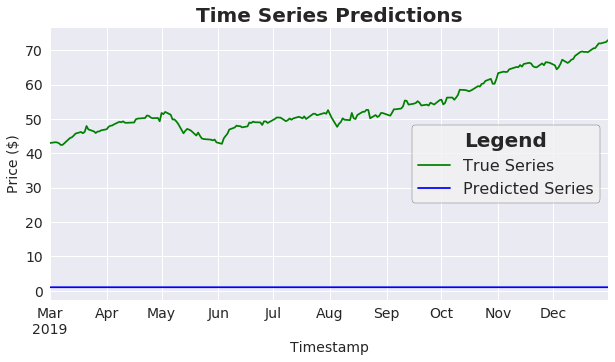

In [98]:
%time
evaluate_model(arima_test[pred_start:pred_end].interpolate(), arima_preds.interpolate(), arima_train)

<a id="DeepAR-Model"></a>
# 2. DeepAR Model
<a id="load-data-2"></a>
## 2.1 Loading Data - Upload to S3
Data is to be uploaded to S3 to give the estimator access to it.

Steps include:
- Create sagemaker role and session to train a model in.
- Save train, test and model data to the default S3 bucket.

In [54]:
import boto3
import sagemaker

In [55]:
# Create role and session
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/inspect.py:1146: ResourceWarning: unclosed <ssl.SSLSocket fd=48, family=AddressFamily.AF_INET, type=2049, proto=6, laddr=('172.16.60.77', 49402), raddr=('52.95.81.200', 443)>
  for param in sig.parameters.values():
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/inspect.py:1146: ResourceWarning: unclosed <socket.socket fd=47, family=AddressFamily.AF_INET, type=2049, proto=6, laddr=('172.16.60.77', 43946), raddr=('169.254.169.254', 80)>
  for param in sig.parameters.values():
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/inspect.py:1146: ResourceWarning: unclosed <socket.socket fd=44, family=AddressFamily.AF_INET, type=2049, proto=6, laddr=('172.16.60.77', 43678), raddr=('169.254.169.254', 80)>
  for param in sig.parameters.values():
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/inspect.py:1146: ResourceWarning: unclosed <socket.socket fd=49, family=AddressFamily.AF_INET, type

In [56]:
# Save data
dar_train_key = os.path.join(json_data_dir, 'train.json')
dar_test_key = os.path.join(json_data_dir, 'test.json')

s3_prefix = 'deepar-aapl-stock'
dar_train_prefix = f'{s3_prefix}/train'
dar_test_prefix = f'{s3_prefix}/test'

deepar_train_path = sagemaker_session.upload_data(dar_train_key, bucket=bucket, key_prefix=dar_train_prefix)
print(f'Training data successfully stored in: {deepar_train_path}')
deepar_test_path = sagemaker_session.upload_data(dar_test_key, bucket=bucket, key_prefix=dar_test_prefix)
print(f'Test data successfully stored in: {deepar_test_path}')

Training data successfully stored in: s3://sagemaker-ap-south-1-792863643153/deepar-aapl-stock/train/train.json
Test data successfully stored in: s3://sagemaker-ap-south-1-792863643153/deepar-aapl-stock/test/test.json


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: ResourceWarning: unclosed <ssl.SSLSocket fd=46, family=AddressFamily.AF_INET, type=2049, proto=6, laddr=('172.16.60.77', 43226), raddr=('52.219.64.119', 443)>
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: ResourceWarning: unclosed <ssl.SSLSocket fd=46, family=AddressFamily.AF_INET, type=2049, proto=6, laddr=('172.16.60.77', 43228), raddr=('52.219.64.119', 443)>


<a id="define-hyperparameters-2"></a>
## 2.2 Instantiating Estimator and Setting Hyperparameters
Creating a base estimator and specifying a container image that contains the DeepAR model. Getting container image with DeepAR model using `get_image_uri` method.

In [57]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name,
                           'forecasting-deepar')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [58]:
from sagemaker.estimator import Estimator

# Specifying location to save model artifacts
output_path = f's3://{bucket}/{s3_prefix}/output'

# Instantiating a DeepAR model
model = Estimator(image_name=image_name,
                  sagemaker_session=sagemaker_session,
                  role=role,
                  train_instance_count=1,
                  train_instance_type='ml.p2.xlarge',
                  output_path=output_path)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


### Setting Hyperparameters
Following are the required hyperparameters:
1. `epochs`: the maximum number of time the neural network should pass through the data.
    > Can be adjusted by viewing the change in errors after every epoch.
2. `time_freq`: the granularity of the time series provided.
    > It is **`D`** (Daily) for the data we have.
3. `prediction_length`: number of `time_freq` steps the model is trained to make predictions for.
    > It is 10 months as decided upon earlier, which is about **`300` days**.
4. `context_length`: number of `time_freq` steps that will be provided to the model before making a prediction.
    > As it is reccommended to start with context_length = prediction_length **`300` days** will be used. DeepAR model will "look further back in the time series" if needed for lag, hence it is not necessary to set this value to be a high value.
    
*Note: `context_length` can later be tuned to see if there are any improvements in the model.*

Some optional hyperparameters that I will modify include:
- `early_stopping_patience`: 7 (Default: None)
- `learning_rate`: 0.001 (Default: 0.001)
- `mini_batch_size`: 256 (Default: 128)
- `num_cells`: 70 (Default: 40)
- `num_eval_samples`: 300 (Default: 100)
- `num_layers`: 2 (Default: 2)

In [59]:
%time
hyperparameters = {
    "context_length": "300",
    "prediction_length": "300",
    "time_freq": "D",
    "epochs": "70",
    "early_stopping_patience": "7",
    "learning_rate": "0.001",
    "mini_batch_size": "256",
    "num_cells": "50",
    "num_eval_samples": "300",
    "num_layers": "2"
}

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [60]:
model.set_hyperparameters(**hyperparameters)

<a id="train-model-2"></a>
## 2.3 Train DeepAR Estimator

In [ ]:
%time

data_channels = {
    "train": deepar_train_path,
    "test": deepar_test_path
}

model.fit(inputs=data_channels)
%notify

<IPython.core.display.Javascript object>

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
2020-10-31 17:01:05 Starting - Starting the training job...
2020-10-31 17:01:07 Starting - Launching requested ML instances......
2020-10-31 17:02:12 Starting - Preparing the instances for training.

<a id="evaluate-performance-2"></a>
## 2.4 Deploy and Evaluate Model Perfomance
First step is to deploy the model as an endpoint.

### Deploy Model

In [ ]:
%time

predictor = model.deploy(initial_count_instance=1,
                         instance_type='ml.m4.xlarge',
                         content_type="application/json")

### Prepare Data for Inference
For inference, the endpoint expects the data to be in a particulate JSON request format.

> **Source**: [DeepAR Inference Formats](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html)

Example (from **Source**):
```
{
    "instances": [
        {
            "start": "2009-11-01 00:00:00",
            "target": [4.0, 10.0, "NaN", 100.0, 113.0],
            "cat": [0, 1],
            "dynamic_feat": [[1.0, 1.1, 2.1, 0.5, 3.1, 4.1, 1.2, 5.0, ...]]
        },
        {
            "start": "2012-01-30",
            "target": [1.0],
            "cat": [2, 1],
            "dynamic_feat": [[2.0, 3.1, 4.5, 1.5, 1.8, 3.2, 0.1, 3.0, ...]]
        }
    ],
    "configuration": {
         "num_samples": 50,
         "output_types": ["mean", "quantiles", "samples"],
         "quantiles": ["0.5", "0.9"]
    }
}
```
The following function will create and return a JSON object in the above format, encoded in `utf-8`.

In [ ]:
def get_json_request(time_series_list: list,
                     num_samples: int = 50,
                     quantiles: list = ['0.3', '0.5', '0.7']):
    """Converts the series input into a JSON request format that is acceptable by DeepAR predictor."""
    
    instances = []
    for ts in time_series_list:
        # A json line is to be created for each of the time series.
        instances.append({
            "start": str(ts.index[0]),
            "target": list(ts)
        })
    
    configuration_data = {
        "num_samples": num_samples,
        "output_types": ["quantiles"],
        "quantiles": quantiles
    }
    
    request = {
        "instances": instances,
        "configuration": configuration_data
    }
    
    return json.dumps(request).encode('utf-8')


def json_to_predictions(json_prediction):
    """The function converts predictions recieved from DeepAR, JSON format from the endpoint into a
    list of prediction data.
    
    Args:
        json_prediction (json obj): json object recieved from the model predictor. Encoded in utf-8
    
    Returns:
        list of pd.DataFrame: each dataframe contains predictions for a particular time series.
    """
    print('Decoding data...')
    data = json.loads(json_prediction.decode('utf-8'))
    predictions = []
    
    for prediction in data['predictions']:
        predictions.append(pd.DataFrame(prediction['quantiles']))
    
    print('List creation completed.')
    return predictions

### Get Test Predictions

In this section, the `six` training series created before will be used to be get predictions from the model. These predicitons then will be evaluated with MAPE metric and a visual plot.

In [ ]:
from helper_functions import create_time_series, create_training_series

In [ ]:
test_ts_list = create_time_series(aapl_updated['Adj Close'], 3)
months_prediction_length = 10
train_ts_list = create_training_series(test_ts_list, months_prediction_length)

json_ts_request = get_json_request(train_ts_list)

json_prediction = predictor.predict(json_ts_request)

In [ ]:
predictions_list = json_to_predictions(json_prediction)

print(predictions_list[0].head(10))

## Display Results
A graph with the quantiles plotted will be displayed.

In [ ]:
def display_results(predictions_list, test_ts_list):
    """Plots the predictions with upper and lower quantiles against actual values.
    
    Args:
        predictions_list (list): list of pd.DataFrame objects for each training time series.
        test_ts_list (list): list of test series that contain true values of the time series.
    
    Returns: None
    """
    for k in range(len(prediction_list)):
        plt.figure(figsize=(12,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts[k][-prediction_length:]
            plt.plot(range(len(target)), target, label='target')
        # get the quantile values at 30 and 70%
        
    num_rows = len(predictions_list)
    
    fig, axes = plt.subplots(nrows=num_rows,
                             ncols=1,
                             figsize=(10*num_rows, 10))
    
    for ax, true_ts, pred_ts in zip(axes, test_ts_list, predictions_list):
        true_ts.plot(color='black', ax=ax,
                     label='True Time Series')
        pred_ts.plot(color='green', ax=ax,
                     label='Predicted Time Series')

        ax.set_title('Predicted and Real Time Series',
                     fontdict={'size': 20, 'weight': 'bold'})
        ax.set_xlabel('Timestamp', fontdict={"size": 14})
        ax.set_ylabel('Price ($)', fontdict={"size": 14})
        p30 = pred_ts['0.3']
        p70 = pred_ts['0.7']
        # fill the 40% confidence interval
        plt.fill_between(p30.index, p30, p70, color='blue', alpha=0.5, label='40% confidence interval')
        # plot the median prediction line
        pred_ts['0.5'].plot(label='prediction median')
        plt.legend(loc='best')
        leg = ax.legend(fontsize=16, frameon=True)
        leg.get_frame().set_color('#F2F2F2')
        leg.get_frame().set_edgecolor('black')
        leg.set_title("Legend", prop={"size": 20, "weight": 'bold'})
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)     

In [ ]:
display_results(predictions_list, test_ts_list)

<a id="hyperparameter-tuning-2"></a>
## 2.5 Hyperparameter Tuning - DeepAR

<a id="generate-predictions-2"></a>
## 2.6 Generate Predictions - DeepAR
Generating predictions for the first 10 months of 2020.

In [ ]:
start_time = datetime.datetime(2020, 1, 1)

# format the request_data
# with "instances" and "configuration"
configuration = {"num_samples": 300, 
                 "output_types": ["quantiles"], 
                 "quantiles": ['0.3', '0.5', '0.7']}

request_data = {"instances": [{"start": str(start_time),
                              "target": []}],
                "configuration": configuration}


# create JSON input
json_request = json.dumps(request_data).encode('utf-8')

print('Requesting prediction for '+ start_time)

In [ ]:
json_prediction = predictor.predict(json_request)

prediction_2020 = json_to_predictions(json_prediction)

In [ ]:
end_time = max(prediction_2020[0].index.date)
test_ts_2020 = [aapl_updated['Adj Close'][start_time:end_time]]

display_results(prediction_2020, test_ts_2020)

In [ ]:
predictor.delete_endpoint()

In [ ]:
evaluate_model(test_ts_2020[0], prediction_2020[0]['0.5'])